In [216]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
MAX_SENT_LENGTH = 25
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.init as I
import pandas as pd

In [217]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [218]:
train_data = pd.read_csv('snli_train.tsv',sep = '\t')
val_data = pd.read_csv('snli_val.tsv',sep = '\t')

In [219]:
def build_vocab(data):
    all_tokens = compute_all_tokens(data)
    token_counter = Counter(all_tokens)
#     print(token_counter)
    vocab = token_counter.keys()
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<PAD>', '<UNK>'] + id2token
    token2id['<PAD>'] = PAD_IDX 
    token2id['<UNK>'] = UNK_IDX
    return token2id, id2token

In [220]:
punctuations = string.punctuation
def tokenize(sent):
    tokens = sent.split()
    return [token for token in tokens]

In [221]:
def compute_all_tokens(data):
    all_tokens_list = []
    temp1 = data['sentence1'].apply(tokenize)
    temp2 = data['sentence2'].apply(tokenize)
    for i in temp1:
        all_tokens_list += i
    for i in temp2:
        all_tokens_list += i
    return all_tokens_list

In [222]:
token2id, id2token = build_vocab(train_data)

In [223]:
token2id['<PAD>']

0

In [224]:
words_to_load = 200000

import numpy as np

with open('/scratch/ark576/fasttext/crawl-300d-2M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = []
    idx2words[0] = '<PAD>'
    idx2words[1] = '<UNK>'
    ordered_words.append('<PAD>')
    ordered_words.append('<UNK>')
    words['<PAD>'] = 0
    words['<UNK>'] = 1
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i+2, :] = np.asarray(s[1:])
        words[s[0]] = i+2
        idx2words[i+2] = s[0]
        ordered_words.append(s[0])

In [225]:
def filtered_vocab(token2id, id2token, ordered_words):
    new_token2id = {}
    new_id2token = []
    words = set(ordered_words)
    for w in id2token:
        if w in words:
            new_id2token.append(w)
            new_token2id[w] = len(new_id2token)-1
    return new_token2id, new_id2token

In [226]:
new_token2id, new_id2token = filtered_vocab(token2id,id2token,ordered_words)

In [227]:
def build_embedding_mat(id2token):
    new_embeddings = np.zeros((len(id2token),300))
    for i,w in enumerate(id2token):
        new_embeddings[i,:] = loaded_embeddings[words[w]]
    return new_embeddings
    

In [228]:
new_embeddings = build_embedding_mat(new_id2token)

In [229]:
new_embeddings.shape

(20523, 300)

In [231]:
vocab_words = set(ordered_words)
def idxize_sent(tokens, words = words):
    idx_list = []
    for w in tokens:
        if w in vocab_words:
            idx_list.append(words[w])
        else:
            idx_list.append(words['<UNK>'])
    return idx_list

In [232]:
def preprocess_data_set(data):
    print('Tokenizing Sentence')
    data['sent1_tokenize'] = data['sentence1'].apply(tokenize)
    data['sent2_tokenize'] = data['sentence2'].apply(tokenize)
    print('Tokenizing finished, saving the lengths of sentences')
    data['sent1_len'] = data['sent1_tokenize'].apply(len)
    data['sent2_len'] = data['sent2_tokenize'].apply(len)
    print('Lenghts saved, Converting tokens to idx')
    data['sent1_idx'] = data['sent1_tokenize'].apply(idxize_sent)
    data['sent2_idx'] = data['sent2_tokenize'].apply(idxize_sent)
    print('Conversion completed, Mapping Labels to int')
    mapping = {'contradiction':0,'neutral':1,'entailment':2}
    data['label_idx'] = data['label'].map(mapping)
    return data

In [233]:
def idx_to_vect(idxs):
    list_word_vec = []
    for i in idxs:
        list_word_vec.append(loaded_embeddings[i])
    return np.vstack(list_word_vec)

In [234]:
train_data = preprocess_data_set(train_data)

Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int


In [235]:
train_data.head()

,sentence1,sentence2,label,sent1_tokenize,sent2_tokenize,sent1_len,sent2_len,sent1_idx,sent2_idx,label_idx
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral,"[A, young, girl, in, a, pink, shirt, sitting, ...","[A, young, girl, watching, the, sunset, over, ...",17,10,"[88, 861, 795, 10, 9, 2823, 3362, 1820, 16, 9,...","[88, 861, 795, 1120, 4, 6962, 107, 4, 309, 5]",1
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment,"[A, woman, is, smiling, while, the, man, next,...","[Two, people, are, next, to, each, other, .]",22,8,"[88, 669, 11, 6287, 149, 4, 289, 279, 7, 77, 1...","[1128, 90, 25, 279, 7, 193, 94, 5]",2
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral,"[Across, the, river, ,, you, can, see, a, larg...","[The, large, building, is, full, of, apartment...",11,9,"[10127, 4, 2031, 3, 23, 57, 109, 9, 432, 514, 5]","[22, 432, 514, 11, 300, 8, 4932, 6, 10063]",1
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction,"[a, man, in, white, shorts, and, a, black, shi...","[A, man, is, riding, a, jetski, on, the, ocean...",14,10,"[9, 289, 10, 638, 6378, 6, 9, 622, 3362, 11, 5...","[88, 289, 11, 2794, 9, 144101, 16, 4, 3166, 5]",0
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction,"[Four, black, dogs, run, together, on, bright,...","[Four, dogs, are, preparing, to, be, launched,...",10,10,"[3682, 622, 1581, 311, 404, 16, 2347, 1111, 41...","[3682, 1581, 25, 3718, 7, 41, 2541, 103, 500, 5]",0


In [236]:
val_data = preprocess_data_set(val_data)

Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int


In [237]:
val_data.head()

,sentence1,sentence2,label,sent1_tokenize,sent2_tokenize,sent1_len,sent2_len,sent1_idx,sent2_idx,label_idx
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction,"[Three, women, on, a, stage, ,, one, wearing, ...","[There, are, two, women, standing, on, the, st...",53,8,"[2452, 347, 16, 9, 1010, 3, 44, 1654, 1067, 17...","[280, 25, 127, 347, 1928, 16, 4, 1010]",0
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment,"[Four, people, sit, on, a, subway, two, read, ...","[Multiple, people, are, on, a, subway, togethe...",22,17,"[3682, 90, 1670, 16, 9, 11535, 127, 203, 465, ...","[8889, 90, 25, 16, 9, 11535, 404, 3, 17, 193, ...",2
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment,"[bicycles, stationed, while, a, group, of, peo...","[People, get, together, near, a, stand, of, bi...",9,9,"[13166, 27392, 149, 9, 298, 8, 90, 24136, 5]","[903, 72, 404, 566, 9, 1079, 8, 13166, 5]",2
3,Man in overalls with two horses .,a man in overalls with two horses,entailment,"[Man, in, overalls, with, two, horses, .]","[a, man, in, overalls, with, two, horses]",7,7,"[1929, 10, 41603, 17, 127, 3313, 5]","[9, 289, 10, 41603, 17, 127, 3313]",2
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment,"[Man, observes, a, wavelength, given, off, by,...","[The, man, is, examining, what, wavelength, is...",11,13,"[1929, 20376, 9, 17012, 352, 179, 35, 78, 3913...","[22, 289, 11, 9420, 73, 17012, 11, 352, 179, 3...",2


In [238]:
# train_data, val_data = train_test_split(data, test_size = 0.2, stratify = data['label'])

In [239]:
# pickling(train_data,'train_SNLI_data.p')

In [240]:
# pickling(val_data,'val_SNLI_data.p')

In [241]:
def check_1s(x):
    if 1 in set(x):
        return 1
    else:
        return 0

In [242]:
a = train_data['sent2_idx'].apply(check_1s)

In [243]:
np.sum(a)/a.shape[0]

0.02633

In [245]:
MAX_SENTENCE_LENGTH = 50

import numpy as np
import torch
from torch.utils.data import Dataset

class SNLI(Dataset):
    
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, key):
        data_name = self.df.iloc[key].name
        sent1_idxs = self.df['sent1_idx'].iloc[key][:MAX_SENTENCE_LENGTH]
        m_sent1 = np.array(sent1_idxs)==1
        sent2_idxs = self.df['sent2_idx'].iloc[key][:MAX_SENTENCE_LENGTH]
        m_sent2 = np.array(sent2_idxs)==1
#         sent1_vec = torch.from_numpy(idx_to_vect(sent1_idxs)).type(torch.FloatTensor)
#         sent2_vec = torch.from_numpy(idx_to_vect(sent2_idxs)).type(torch.FloatTensor)
        label = self.df['label_idx'].iloc[key]
        return [sent1_idxs,sent2_idxs, len(sent1_idxs),len(sent2_idxs), int(label),data_name,m_sent1,m_sent2]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sent1_list = []
    sent2_list = []
    label_list = []
    sent1_length_list = []
    sent2_length_list = []
    data_name_list = []
    m_sent1_list = []
    m_sent2_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        sent1_length_list.append(datum[2])
        sent2_length_list.append(datum[3])
        data_name_list.append(datum[5])
    # padding
    for datum in batch:
        padded_sent1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_sent2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        padded_m_sent1 = np.pad(np.array(datum[6]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_m_sent2 = np.pad(np.array(datum[7]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        sent1_list.append(padded_sent1)
        sent2_list.append(padded_sent2)
        m_sent1_list.append(padded_m_sent1)
        m_sent2_list.append(padded_m_sent2)
    ind_dec_order = np.argsort(sent1_length_list)[::-1]
    sent1_list = np.array(sent1_list)[ind_dec_order].astype(int)
    sent2_list = np.array(sent2_list)[ind_dec_order].astype(int)
    sent1_length_list = np.array(sent1_length_list)[ind_dec_order]
    sent2_length_list = np.array(sent2_length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    m_sent1_list = np.array(m_sent1_list)[ind_dec_order].astype(float)
    m_sent2_list = np.array(m_sent2_list)[ind_dec_order].astype(float)
    data_name_list = np.array(data_name_list)[ind_dec_order]
    return [torch.from_numpy(np.array(sent1_list)),torch.from_numpy(np.array(sent2_list)), \
            torch.LongTensor(sent1_length_list),torch.LongTensor(sent2_length_list),torch.LongTensor(label_list),\
           data_name_list, torch.FloatTensor(m_sent1_list),torch.FloatTensor(m_sent2_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 128
train_dataset = SNLI(train_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLI(val_data)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)
# genre = np.unique(val_data['genre'])
# val_data_loaders = []
# train_dataset = SNLI(train_data)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=SNLI_collate_func,
#                                            shuffle=True)
# for g in genre:
#     val_dataset = SNLI(val_data[val_data['genre'] == g])
#     val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                                batch_size=BATCH_SIZE,
#                                                collate_fn=SNLI_collate_func,
#                                                shuffle=True)
#     val_data_loaders.append(val_loader)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [246]:
for i, (j) in enumerate(train_loader):
    print (j[0].size())
    print (j[1].size())
    print (j[2].size())
    print (j[3].size())
    print (j[4].size())
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])
torch.Size([128])
torch.Size([128])


In [247]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, dropout, vocab_size = loaded_embeddings.shape[0],):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(2*hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)
        self.dropout = dropout

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.zeros(2*2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x1,x2,len1,len2,m1,m2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden = self.init_hidden(batch_size)
        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, len1.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, len2.numpy(), batch_first=True)
        # fprop though RNN
        _, h1 = self.gru(embed1, self.hidden)
#         self.hidden = self.init_hidden(batch_size)
        _, h2 = self.gru(embed2, self.hidden)
        # undo packing
#         gru_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_1, batch_first=True)
#         gru_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_2, batch_first=True)
        # sum hidden activations of RNN across time
#         gru_out_1 = torch.sum(gru_out_1, dim = 1)
#         gru_out_2 = torch.sum(gru_out_2, dim = 1)
        
#         print(h1.size())
#         print(h2.size())
        h1 = torch.sum(h1,dim = 0)
        h2 = torch.sum(h2,dim = 0)
        #cat hidden rep
        x = torch.cat([h1,h2],dim = 1)
        x = F.dropout(F.relu(self.linear1(x)),p = self.dropout)
        x = self.linear2(x)
        return x

In [248]:
def init_weights(m):
    if (type(m) == nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)
#     if type(m) == nn.GRU:
#         torch.nn.init.xavier_normal_(m.weight_hh_l0_reverse)
#         torch.nn.init.xavier_normal_(m.weight_ih_l0_reverse)
#         torch.nn.init.xavier_normal_(m.weight_hh_l0)
#         torch.nn.init.xavier_normal_(m.weight_ih_l0)

In [249]:
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    predictions = []
    for batch in loader:
        out = model(batch[0].cuda(), batch[1].cuda(), batch[2],batch[3], batch[6].cuda(),batch[7].cuda())
        outputs = F.softmax(out, dim=1)
        predicted = outputs.max(1, keepdim=True)[1].cpu()
        loss = criterion(outputs,batch[4].cuda())
        total += batch[4].size(0)
        correct += predicted.eq(batch[4].view_as(predicted)).sum().item()
        predictions.append((batch[5],predicted.squeeze().numpy(),batch[4].numpy()))
    return (100 * correct / total), loss.item(), np.concatenate(predictions,axis = 1).T

In [270]:
mask = np.zeros(loaded_embeddings.shape[0])
mask[1] = 1
def train_model(model,criterion,optimizer,train_loader,val_loader, name, num_epochs = 5, val_every = 3):

    loss_dict = {'train':[],'val':[]}
    acc_dict = {'train':[],'val':[]}
    best_acc = 0
    best_pred = None
    best_wts = None
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (batch) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(batch[0].cuda(), batch[1].cuda(), batch[2],batch[3],batch[6].cuda(),batch[7].cuda())
            loss = criterion(outputs, batch[4].cuda())
            loss.backward()
            model.embedding.weight.grad[torch.from_numpy(mask) == 0]=0
            optimizer.step()
            out = F.softmax(outputs, dim=1)
            if i>0 and i%val_every == 0:
                predicted = out.max(1, keepdim=True)[1]
                total += batch[4].size(0)
                correct += predicted.eq(batch[4].cuda().view_as(predicted)).sum().item()
                loss_dict['train'].append(loss.item())
                acc_dict['train'].append((100 * correct / total))
    #         loss_2 = criterion2(torch.round(outputs[1]), label_rat_batch)
    #         loss = loss_2
            # validate every 100 iterations
            if i>0 and i%val_every == 0:
                # validate
                val_acc, val_loss,pred= test_model(val_loader, model, criterion)
                loss_dict['val'].append(val_loss)
                acc_dict['val'].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                                   epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                if val_acc > best_acc:
                    torch.save(model,'/scratch/ark576/NLP_HW_2/'+name)
                    best_pred = pred
                    best_acc = val_acc
                    best_wts = model.state_dict()
    print('Best Accuracy:{}'.format(best_acc))
    pickling(loss_dict,'/scratch/ark576/NLP_HW_2/'+name+'_loss_hist')
    pickling(acc_dict,'/scratch/ark576/NLP_HW_2/'+name+'_acc_hist')
    pickling(best_pred,'/scratch/ark576/NLP_HW_2/'+name+'_preds')
    model.load_state_dict(best_wts)
    return model, loss_dict, acc_dict, best_pred

In [251]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, dropout, vocab_size = loaded_embeddings.shape[0],):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.gru = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)
        self.dropout = dropout

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(1*2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x1,x2,len1,len2,m1,m2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, len1.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, len2.numpy(), batch_first=True)
        # fprop though RNN
        self.gru.flatten_parameters()
        _, h1 = self.gru(embed1, self.hidden)
        _, h2 = self.gru(embed2, self.hidden)
        # undo packing
#         gru_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_1, batch_first=True)
#         gru_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_2, batch_first=True)
        # sum hidden activations of RNN across time
#         gru_out_1 = torch.sum(gru_out_1, dim = 1)
#         gru_out_2 = torch.sum(gru_out_2, dim = 1)
        
#         print(h1.size())
#         print(h2.size())
        h1 = torch.sum(h1,dim = 0)
        h2 = torch.sum(h2,dim = 0)
        #cat hidden rep
        x = h1*h2
        x = F.dropout(F.relu(self.linear1(x)),p = self.dropout)
        x = self.linear2(x)
        return x

In [252]:
class CNN(nn.Module):
    def __init__(self, hidden_size,ks , emb_size = 300, vocab_size = loaded_embeddings.shape[0]):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(loaded_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))

        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)

    def forward(self,x1,x2,len1,len2,m1,m2):
        batch_size, seq_len1 = x1.size()
        batch_size, seq_len2 = x1.size()
        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        
        hidden1 = F.max_pool1d(hidden1.transpose(1,2), seq_len1).squeeze()
        hidden2 = F.max_pool1d(hidden2.transpose(1,2), seq_len1).squeeze()
        x = torch.cat([hidden1,hidden2],dim = 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Pretraining GRU Model

In [271]:
gru = GRU(300,400,dropout = 0).cuda()

In [272]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(200002, 300, padding_idx=0)
  (gru): GRU(300, 400, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=3, bias=True)
)

In [273]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [274]:
criterion = nn.CrossEntropyLoss()

In [275]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_loader,val_loader,\
                                                              'gru_hd=400_t2_dp=0_max_len=50_multh_200k',num_epochs=5, val_every = 100)

Epoch: [1/5], Step: [101/782], Validation Acc: 48.2


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/782], Validation Acc: 55.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [301/782], Validation Acc: 59.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [401/782], Validation Acc: 60.4


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [501/782], Validation Acc: 59.8
Epoch: [1/5], Step: [601/782], Validation Acc: 58.9
Epoch: [1/5], Step: [701/782], Validation Acc: 64.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [101/782], Validation Acc: 65.0


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [201/782], Validation Acc: 65.4


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [301/782], Validation Acc: 64.9
Epoch: [2/5], Step: [401/782], Validation Acc: 65.8


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [501/782], Validation Acc: 65.9


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [601/782], Validation Acc: 68.4


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/5], Step: [701/782], Validation Acc: 68.8


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [3/5], Step: [101/782], Validation Acc: 66.7
Epoch: [3/5], Step: [201/782], Validation Acc: 65.3
Epoch: [3/5], Step: [301/782], Validation Acc: 66.5
Epoch: [3/5], Step: [401/782], Validation Acc: 66.7
Epoch: [3/5], Step: [501/782], Validation Acc: 69.1


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [3/5], Step: [601/782], Validation Acc: 67.1
Epoch: [3/5], Step: [701/782], Validation Acc: 69.5


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [4/5], Step: [101/782], Validation Acc: 66.1
Epoch: [4/5], Step: [201/782], Validation Acc: 64.9
Epoch: [4/5], Step: [301/782], Validation Acc: 66.0
Epoch: [4/5], Step: [401/782], Validation Acc: 69.0
Epoch: [4/5], Step: [501/782], Validation Acc: 68.0
Epoch: [4/5], Step: [601/782], Validation Acc: 66.2
Epoch: [4/5], Step: [701/782], Validation Acc: 68.0
Epoch: [5/5], Step: [101/782], Validation Acc: 67.6
Epoch: [5/5], Step: [201/782], Validation Acc: 68.3
Epoch: [5/5], Step: [301/782], Validation Acc: 67.8
Epoch: [5/5], Step: [401/782], Validation Acc: 66.3
Epoch: [5/5], Step: [501/782], Validation Acc: 66.6
Epoch: [5/5], Step: [601/782], Validation Acc: 66.9
Epoch: [5/5], Step: [701/782], Validation Acc: 67.4
Best Accuracy:69.5


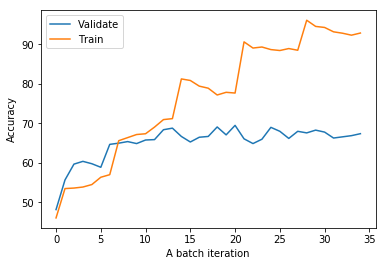

In [276]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

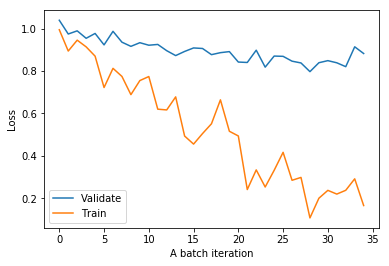

In [277]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

In [278]:
best_pred_gru = unpickling('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k_preds')

In [392]:
correct_preds = best_pred_gru[best_pred_gru[:,1] == best_pred_gru[:,2]]

In [393]:
filtered_correct_df = val_data.loc[correct_preds[:,0]]

In [405]:
correct_preds_text = correct_preds.astype(str)
correct_preds_text[correct_preds_text[:,1]=='0'] = 'contradiction'
correct_preds_text[correct_preds_text[:,1]=='1'] = 'neutral'
correct_preds_text[correct_preds_text[:,1]=='2'] = 'entailment'
idx = correct_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_correct_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_correct_df.iloc[j]['sentence2'])
    print('Label:',filtered_correct_df.iloc[j]['label'] )
    print('Predicted Label:',correct_preds_text[correct_preds[:,0] == i][0,1])
    print('='*50)

647
--------------------------------------------------
Sentence 1: Three women , two wearing red shirts and one wearing a purple shirt , and a man , wearing a light blue shirt , jump on a basketball court with balls in their hands .
Sentence 2: Three people 's are eating in hotel .
Label: contradiction
Predicted Label: contradiction
389
--------------------------------------------------
Sentence 1: Two men on a basketball court one in white and red the other in blue , the player in white is throwing the ball in while teammates look on .
Sentence 2: The men are playing basketball .
Label: entailment
Predicted Label: entailment
479
--------------------------------------------------
Sentence 1: A man with an open shirt and glasses holding a microphone and another man in a bowler hat and plaid suit using a bow on an instrument .
Sentence 2: The singer and musician are in the bathroom .
Label: contradiction
Predicted Label: contradiction
29
--------------------------------------------------

In [401]:
incorrect_preds = best_pred_gru[best_pred_gru[:,1] != best_pred_gru[:,2]]

In [402]:
filtered_incorrect_df = val_data.iloc[incorrect_preds[:,0]]

In [406]:
incorrect_preds_text = incorrect_preds.astype(str)
incorrect_preds_text[incorrect_preds_text[:,1]=='0'] = 'contradiction'
incorrect_preds_text[incorrect_preds_text[:,1]=='1'] = 'neutral'
incorrect_preds_text[incorrect_preds_text[:,1]=='2'] = 'entailment'
idx = incorrect_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_incorrect_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_incorrect_df.iloc[j]['sentence2'])
    print('Label:',filtered_incorrect_df.iloc[j]['label'] )
    print('Predicted Label:',incorrect_preds_text[incorrect_preds[:,0] == i][0,1])
    print('='*50)

903
--------------------------------------------------
Sentence 1: A man in a brown jacket , white shirt , and dark slacks is holding a book with his finger on the page while sitting on a wooden floor , and leaning against a yellow wall with a door on one side and cloths on hangers on the other side .
Sentence 2: A man sits on a wooden floor building a model ship .
Label: contradiction
Predicted Label: neutral
650
--------------------------------------------------
Sentence 1: A young man , without apparent protective gear , is on a bicycle jumping over small hills of sand or gravel , with a long bridge and tall buildings in the background .
Sentence 2: A young male is riding his bicycle over small hills .
Label: entailment
Predicted Label: neutral
431
--------------------------------------------------
Sentence 1: A man with a beard , curly hair and a beard wearing a green shirt and navy blue jacket standing still looking through his red sunglasses .
Sentence 2: A man is crouched down .

# Pretraining the CNN model

In [407]:
cnn = CNN(500,3).cuda()

In [408]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [409]:
criterion = nn.CrossEntropyLoss()

In [411]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_loader,val_loader,\
                                                              'cnn_hd=500_ks=3_cath_200k',num_epochs=7, val_every = 100)

Epoch: [1/7], Step: [101/782], Validation Acc: 52.0


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/7], Step: [201/782], Validation Acc: 55.8


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/7], Step: [301/782], Validation Acc: 56.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/7], Step: [401/782], Validation Acc: 59.1


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/7], Step: [501/782], Validation Acc: 60.5


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/7], Step: [601/782], Validation Acc: 59.4
Epoch: [1/7], Step: [701/782], Validation Acc: 61.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/7], Step: [101/782], Validation Acc: 58.8
Epoch: [2/7], Step: [201/782], Validation Acc: 60.1
Epoch: [2/7], Step: [301/782], Validation Acc: 62.2


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/7], Step: [401/782], Validation Acc: 62.7


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [2/7], Step: [501/782], Validation Acc: 61.1
Epoch: [2/7], Step: [601/782], Validation Acc: 62.6
Epoch: [2/7], Step: [701/782], Validation Acc: 62.3
Epoch: [3/7], Step: [101/782], Validation Acc: 63.3


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [3/7], Step: [201/782], Validation Acc: 63.1
Epoch: [3/7], Step: [301/782], Validation Acc: 62.8
Epoch: [3/7], Step: [401/782], Validation Acc: 61.9
Epoch: [3/7], Step: [501/782], Validation Acc: 62.0
Epoch: [3/7], Step: [601/782], Validation Acc: 63.6


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [3/7], Step: [701/782], Validation Acc: 63.9


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [4/7], Step: [101/782], Validation Acc: 65.2


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [4/7], Step: [201/782], Validation Acc: 63.2
Epoch: [4/7], Step: [301/782], Validation Acc: 64.7
Epoch: [4/7], Step: [401/782], Validation Acc: 65.1
Epoch: [4/7], Step: [501/782], Validation Acc: 61.8
Epoch: [4/7], Step: [601/782], Validation Acc: 64.9
Epoch: [4/7], Step: [701/782], Validation Acc: 64.7
Epoch: [5/7], Step: [101/782], Validation Acc: 62.9
Epoch: [5/7], Step: [201/782], Validation Acc: 63.1
Epoch: [5/7], Step: [301/782], Validation Acc: 62.8
Epoch: [5/7], Step: [401/782], Validation Acc: 64.3
Epoch: [5/7], Step: [501/782], Validation Acc: 63.6
Epoch: [5/7], Step: [601/782], Validation Acc: 65.3


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [5/7], Step: [701/782], Validation Acc: 66.3


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [6/7], Step: [101/782], Validation Acc: 63.5
Epoch: [6/7], Step: [201/782], Validation Acc: 63.0
Epoch: [6/7], Step: [301/782], Validation Acc: 65.0
Epoch: [6/7], Step: [401/782], Validation Acc: 65.1
Epoch: [6/7], Step: [501/782], Validation Acc: 64.7
Epoch: [6/7], Step: [601/782], Validation Acc: 65.0
Epoch: [6/7], Step: [701/782], Validation Acc: 65.3
Epoch: [7/7], Step: [101/782], Validation Acc: 63.2
Epoch: [7/7], Step: [201/782], Validation Acc: 64.1
Epoch: [7/7], Step: [301/782], Validation Acc: 64.0
Epoch: [7/7], Step: [401/782], Validation Acc: 64.9
Epoch: [7/7], Step: [501/782], Validation Acc: 64.8
Epoch: [7/7], Step: [601/782], Validation Acc: 64.5
Epoch: [7/7], Step: [701/782], Validation Acc: 65.6
Best Accuracy:66.3


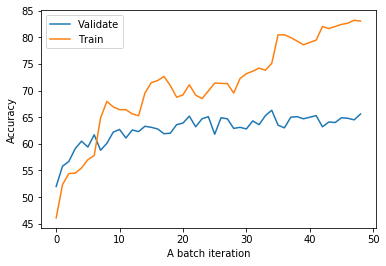

In [412]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

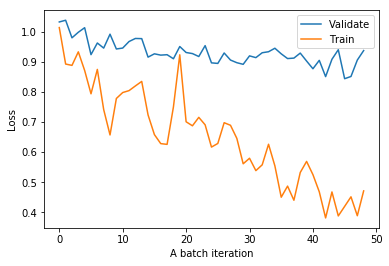

In [413]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

In [414]:
best_pred_cnn = unpickling('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k_preds')

In [415]:
correct_preds = best_pred_gru[best_pred_gru[:,1] == best_pred_gru[:,2]]

In [416]:
filtered_correct_df = val_data.loc[correct_preds[:,0]]

In [417]:
correct_preds_text = correct_preds.astype(str)
correct_preds_text[correct_preds_text[:,1]=='0'] = 'contradiction'
correct_preds_text[correct_preds_text[:,1]=='1'] = 'neutral'
correct_preds_text[correct_preds_text[:,1]=='2'] = 'entailment'
idx = correct_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_correct_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_correct_df.iloc[j]['sentence2'])
    print('Label:',filtered_correct_df.iloc[j]['label'] )
    print('Predicted Label:',correct_preds_text[correct_preds[:,0] == i][0,1])
    print('='*50)

366
--------------------------------------------------
Sentence 1: An Asian man is standing on a rusty dock surrounded by ropes and tires and is sticking a fishing pole into the water in front of him .
Sentence 2: A fisherman is working hard on the dock
Label: neutral
Predicted Label: neutral
223
--------------------------------------------------
Sentence 1: As a referee looks on , a Los Angeles baseball player is falling over the top of a rival player who is just sliding into base .
Sentence 2: The people are playing basketball .
Label: contradiction
Predicted Label: contradiction
29
--------------------------------------------------
Sentence 1: Three cheerful ladies sitting at a table doing a yarn work in a room , at the background are similar groups of ladies doing similar work .
Sentence 2: The ladies are discussing what they are going to do tonight .
Label: neutral
Predicted Label: neutral
741
--------------------------------------------------
Sentence 1: Woman in light blue knit 

In [418]:
incorrect_preds = best_pred_gru[best_pred_gru[:,1] != best_pred_gru[:,2]]

In [419]:
filtered_incorrect_df = val_data.iloc[incorrect_preds[:,0]]

In [420]:
incorrect_preds_text = incorrect_preds.astype(str)
incorrect_preds_text[incorrect_preds_text[:,1]=='0'] = 'contradiction'
incorrect_preds_text[incorrect_preds_text[:,1]=='1'] = 'neutral'
incorrect_preds_text[incorrect_preds_text[:,1]=='2'] = 'entailment'
idx = incorrect_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_incorrect_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_incorrect_df.iloc[j]['sentence2'])
    print('Label:',filtered_incorrect_df.iloc[j]['label'] )
    print('Predicted Label:',incorrect_preds_text[incorrect_preds[:,0] == i][0,1])
    print('='*50)

783
--------------------------------------------------
Sentence 1: A kid in a red and black coat is laying on his back in the snow with his arm in the air and a red sled is next to him .
Sentence 2: It is a cold day .
Label: entailment
Predicted Label: neutral
17
--------------------------------------------------
Sentence 1: A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air .
Sentence 2: A band plays at a beach party .
Label: neutral
Predicted Label: contradiction
913
--------------------------------------------------
Sentence 1: Three sisters , barefoot in pink dresses and who range in age from preschool to teenager are pictured on a beach as they look out at the Ocean .
Sentence 2: Three sisters , barefoot in pink dresses and who range in age from preschool to teenager
Label: entailment
Predicted Label: contradiction
629
--------------------------------------------------
Sent

# Testing the best model on the MNLI data set

In [61]:
train_data = pd.read_csv('mnli_train.tsv',sep = '\t')
val_data = pd.read_csv('mnli_val.tsv',sep = '\t')

In [62]:
train_data = preprocess_data_set(train_data)
val_data = preprocess_data_set(val_data)

Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int
Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int


In [63]:
genre = np.unique(val_data['genre'])
val_data_loaders = []
train_data_loaders = []
for g in genre:
    train_dataset = SNLI(train_data[train_data['genre'] == g])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)
    val_dataset = SNLI(val_data[val_data['genre'] == g])
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=SNLI_collate_func,
                                               shuffle=True)
    val_data_loaders.append(val_loader)
    train_data_loaders.append(train_loader)

# for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

# Validating the pretrained GRU model in MNLI val data set

In [37]:
best_model = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_cath')

In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
acc_list = []
loss_list = []
pred_list = []
for v in val_data_loaders:
    temp_acc, temp_loss, temp_pred = test_model(v,best_model,criterion)
    acc_list.append(temp_acc)
    loss_list.append(temp_loss)
    pred_list.append(temp_pred)

/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


In [40]:
acc_list

[42.51256281407035,
 40.846456692913385,
 40.41916167664671,
 39.004975124378106,
 38.085539714867615]

# Validating the pretrained CNN model in MNLI val data set

In [42]:
best_cnn_model = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath')

In [43]:
criterion = nn.CrossEntropyLoss()

In [46]:
acc_list = []
loss_list = []
pred_list = []
for v in val_data_loaders:
    temp_acc, temp_loss, temp_pred = test_model(v,best_cnn_model,criterion)
    acc_list.append(temp_acc)
    loss_list.append(temp_loss)
    pred_list.append(temp_pred)

In [47]:
acc_list

[41.4070351758794,
 45.07874015748032,
 41.21756487025948,
 41.29353233830846,
 43.58452138492871]

# Fine-tuning the model (CNN) (fiction)

In [97]:
cnn = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k')

In [98]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr = 1e-3)

In [99]:
criterion = nn.CrossEntropyLoss()

In [101]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_data_loaders[0],\
                                                              val_data_loaders[0],'cnn_hd=500_ks=3_cath_200k_ft_fic',num_epochs=6)

Epoch: [1/3], Step: [4/30], Validation Acc: 47.03517587939699
Epoch: [1/3], Step: [7/30], Validation Acc: 46.53266331658291
Epoch: [1/3], Step: [10/30], Validation Acc: 47.23618090452261
Epoch: [1/3], Step: [13/30], Validation Acc: 47.336683417085425
Epoch: [1/3], Step: [16/30], Validation Acc: 45.62814070351759
Epoch: [1/3], Step: [19/30], Validation Acc: 44.52261306532663
Epoch: [1/3], Step: [22/30], Validation Acc: 45.02512562814071
Epoch: [1/3], Step: [25/30], Validation Acc: 45.7286432160804
Epoch: [1/3], Step: [28/30], Validation Acc: 46.030150753768844
Epoch: [2/3], Step: [4/30], Validation Acc: 45.32663316582914
Epoch: [2/3], Step: [7/30], Validation Acc: 45.22613065326633
Epoch: [2/3], Step: [10/30], Validation Acc: 44.92462311557789
Epoch: [2/3], Step: [13/30], Validation Acc: 45.32663316582914
Epoch: [2/3], Step: [16/30], Validation Acc: 45.42713567839196
Epoch: [2/3], Step: [19/30], Validation Acc: 44.824120603015075
Epoch: [2/3], Step: [22/30], Validation Acc: 43.718592964

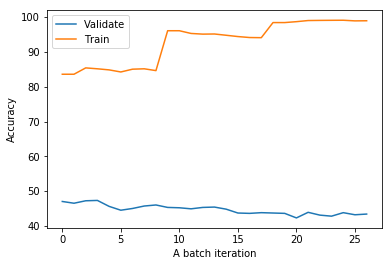

In [102]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

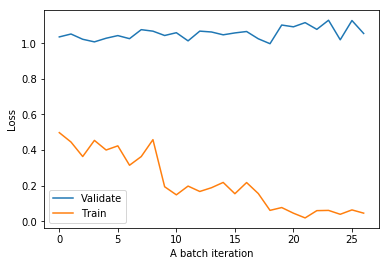

In [103]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (CNN) (government)

In [104]:
cnn = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k')

In [105]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr = 1e-3)

In [106]:
criterion = nn.CrossEntropyLoss()

In [107]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_data_loaders[1],\
                                                              val_data_loaders[1],'cnn_hd=500_ks=3_cath_200k_ft_govt',num_epochs=6)

Epoch: [1/6], Step: [4/31], Validation Acc: 45.767716535433074
Epoch: [1/6], Step: [7/31], Validation Acc: 45.767716535433074
Epoch: [1/6], Step: [10/31], Validation Acc: 44.881889763779526
Epoch: [1/6], Step: [13/31], Validation Acc: 45.669291338582674
Epoch: [1/6], Step: [16/31], Validation Acc: 45.275590551181104
Epoch: [1/6], Step: [19/31], Validation Acc: 44.68503937007874
Epoch: [1/6], Step: [22/31], Validation Acc: 45.07874015748032
Epoch: [1/6], Step: [25/31], Validation Acc: 44.58661417322835
Epoch: [1/6], Step: [28/31], Validation Acc: 45.07874015748032
Epoch: [1/6], Step: [31/31], Validation Acc: 43.7992125984252
Epoch: [2/6], Step: [4/31], Validation Acc: 42.02755905511811
Epoch: [2/6], Step: [7/31], Validation Acc: 43.40551181102362
Epoch: [2/6], Step: [10/31], Validation Acc: 44.29133858267716
Epoch: [2/6], Step: [13/31], Validation Acc: 44.78346456692913
Epoch: [2/6], Step: [16/31], Validation Acc: 44.98031496062992
Epoch: [2/6], Step: [19/31], Validation Acc: 44.5866141

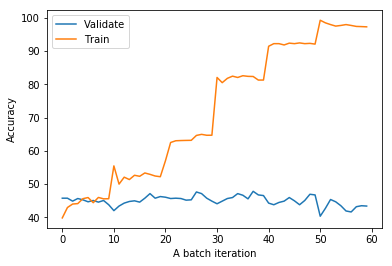

In [108]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

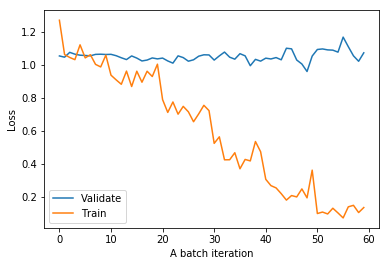

In [109]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (CNN) (slate)

In [110]:
cnn = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k')

In [111]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr = 1e-3)

In [112]:
criterion = nn.CrossEntropyLoss()

In [113]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_data_loaders[2],\
                                                              val_data_loaders[2],'cnn_hd=500_ks=3_cath_200k_ft_slate',num_epochs=6)

Epoch: [1/6], Step: [4/32], Validation Acc: 42.61477045908184
Epoch: [1/6], Step: [7/32], Validation Acc: 41.91616766467066
Epoch: [1/6], Step: [10/32], Validation Acc: 40.7185628742515
Epoch: [1/6], Step: [13/32], Validation Acc: 40.01996007984032
Epoch: [1/6], Step: [16/32], Validation Acc: 40.41916167664671
Epoch: [1/6], Step: [19/32], Validation Acc: 40.91816367265469
Epoch: [1/6], Step: [22/32], Validation Acc: 41.01796407185629
Epoch: [1/6], Step: [25/32], Validation Acc: 40.91816367265469
Epoch: [1/6], Step: [28/32], Validation Acc: 40.91816367265469
Epoch: [1/6], Step: [31/32], Validation Acc: 41.21756487025948
Epoch: [2/6], Step: [4/32], Validation Acc: 41.71656686626746
Epoch: [2/6], Step: [7/32], Validation Acc: 41.81636726546906
Epoch: [2/6], Step: [10/32], Validation Acc: 40.91816367265469
Epoch: [2/6], Step: [13/32], Validation Acc: 41.31736526946108
Epoch: [2/6], Step: [16/32], Validation Acc: 42.81437125748503
Epoch: [2/6], Step: [19/32], Validation Acc: 42.614770459081

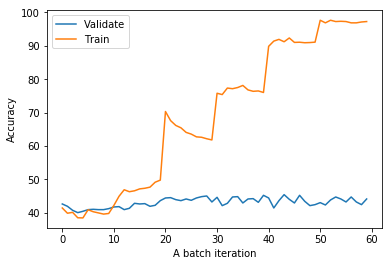

In [114]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

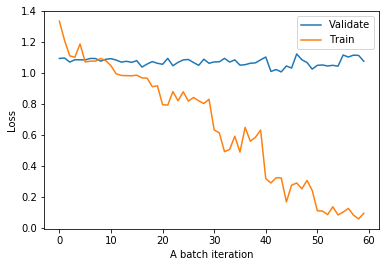

In [115]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (CNN) (telephone)

In [116]:
cnn = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k')

In [117]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr = 1e-3)

In [118]:
criterion = nn.CrossEntropyLoss()

In [119]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_data_loaders[3],\
                                                              val_data_loaders[3],'cnn_hd=500_ks=3_cath_200k_ft_tele',num_epochs=6)

Epoch: [1/6], Step: [4/34], Validation Acc: 44.776119402985074
Epoch: [1/6], Step: [7/34], Validation Acc: 43.582089552238806
Epoch: [1/6], Step: [10/34], Validation Acc: 42.58706467661692
Epoch: [1/6], Step: [13/34], Validation Acc: 41.592039800995025
Epoch: [1/6], Step: [16/34], Validation Acc: 40.8955223880597
Epoch: [1/6], Step: [19/34], Validation Acc: 40.49751243781095
Epoch: [1/6], Step: [22/34], Validation Acc: 40.298507462686565
Epoch: [1/6], Step: [25/34], Validation Acc: 40.8955223880597
Epoch: [1/6], Step: [28/34], Validation Acc: 40.59701492537314
Epoch: [1/6], Step: [31/34], Validation Acc: 40.995024875621894
Epoch: [1/6], Step: [34/34], Validation Acc: 41.89054726368159
Epoch: [2/6], Step: [4/34], Validation Acc: 44.37810945273632
Epoch: [2/6], Step: [7/34], Validation Acc: 44.776119402985074
Epoch: [2/6], Step: [10/34], Validation Acc: 44.07960199004975
Epoch: [2/6], Step: [13/34], Validation Acc: 44.776119402985074
Epoch: [2/6], Step: [16/34], Validation Acc: 44.875621

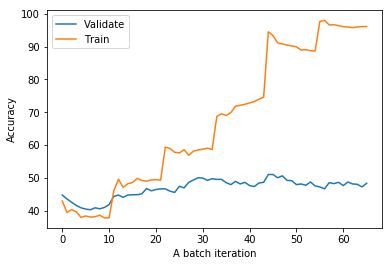

In [120]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

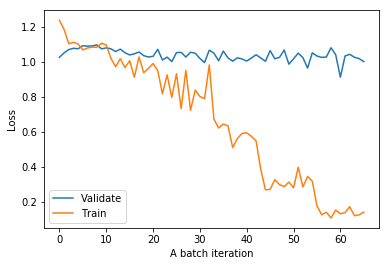

In [121]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (CNN) (travel)

In [122]:
cnn = torch.load('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k')

In [123]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, cnn.parameters()), lr = 1e-3)

In [124]:
criterion = nn.CrossEntropyLoss()

In [125]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,train_data_loaders[4],\
                                                              val_data_loaders[4],'cnn_hd=500_ks=3_cath_200k_ft_travel',num_epochs=6)

Epoch: [1/6], Step: [4/32], Validation Acc: 44.806517311608964
Epoch: [1/6], Step: [7/32], Validation Acc: 44.19551934826884
Epoch: [1/6], Step: [10/32], Validation Acc: 43.17718940936864
Epoch: [1/6], Step: [13/32], Validation Acc: 43.788187372708755
Epoch: [1/6], Step: [16/32], Validation Acc: 43.4826883910387
Epoch: [1/6], Step: [19/32], Validation Acc: 44.70468431771894
Epoch: [1/6], Step: [22/32], Validation Acc: 45.11201629327902
Epoch: [1/6], Step: [25/32], Validation Acc: 44.29735234215886
Epoch: [1/6], Step: [28/32], Validation Acc: 45.41751527494908
Epoch: [1/6], Step: [31/32], Validation Acc: 45.621181262729124
Epoch: [2/6], Step: [4/32], Validation Acc: 45.21384928716904
Epoch: [2/6], Step: [7/32], Validation Acc: 45.5193482688391
Epoch: [2/6], Step: [10/32], Validation Acc: 45.21384928716904
Epoch: [2/6], Step: [13/32], Validation Acc: 44.908350305498985
Epoch: [2/6], Step: [16/32], Validation Acc: 45.41751527494908
Epoch: [2/6], Step: [19/32], Validation Acc: 45.112016293

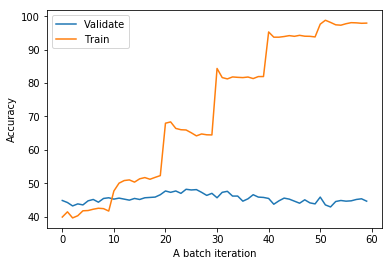

In [126]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

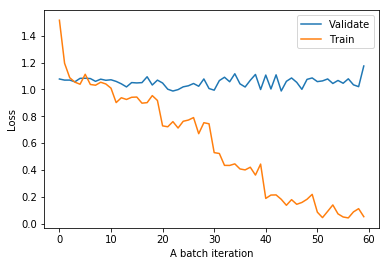

In [127]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (GRU) (fiction)

In [159]:
gru = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k')

In [160]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [161]:
criterion = nn.CrossEntropyLoss()

In [162]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_data_loaders[0],\
                                                              val_data_loaders[0],'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_fic',num_epochs=6)

Epoch: [1/6], Step: [4/30], Validation Acc: 43.41708542713568
Epoch: [1/6], Step: [7/30], Validation Acc: 44.120603015075375
Epoch: [1/6], Step: [10/30], Validation Acc: 44.62311557788945
Epoch: [1/6], Step: [13/30], Validation Acc: 44.52261306532663
Epoch: [1/6], Step: [16/30], Validation Acc: 44.92462311557789
Epoch: [1/6], Step: [19/30], Validation Acc: 45.527638190954775
Epoch: [1/6], Step: [22/30], Validation Acc: 46.4321608040201
Epoch: [1/6], Step: [25/30], Validation Acc: 46.33165829145729
Epoch: [1/6], Step: [28/30], Validation Acc: 45.42713567839196
Epoch: [2/6], Step: [4/30], Validation Acc: 46.733668341708544
Epoch: [2/6], Step: [7/30], Validation Acc: 47.336683417085425
Epoch: [2/6], Step: [10/30], Validation Acc: 48.34170854271357
Epoch: [2/6], Step: [13/30], Validation Acc: 49.14572864321608
Epoch: [2/6], Step: [16/30], Validation Acc: 48.84422110552764
Epoch: [2/6], Step: [19/30], Validation Acc: 49.14572864321608
Epoch: [2/6], Step: [22/30], Validation Acc: 48.44221105

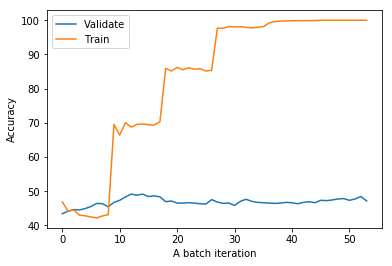

In [163]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

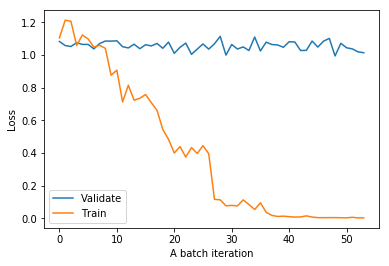

In [164]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (GRU) (goverment)

In [165]:
gru = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k')

In [166]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [167]:
criterion = nn.CrossEntropyLoss()

In [168]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_data_loaders[1],\
                                                              val_data_loaders[1],'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_govt',num_epochs=6)

Epoch: [1/6], Step: [4/31], Validation Acc: 45.17716535433071
Epoch: [1/6], Step: [7/31], Validation Acc: 46.94881889763779
Epoch: [1/6], Step: [10/31], Validation Acc: 47.04724409448819
Epoch: [1/6], Step: [13/31], Validation Acc: 46.94881889763779
Epoch: [1/6], Step: [16/31], Validation Acc: 47.34251968503937
Epoch: [1/6], Step: [19/31], Validation Acc: 46.45669291338583
Epoch: [1/6], Step: [22/31], Validation Acc: 47.93307086614173
Epoch: [1/6], Step: [25/31], Validation Acc: 48.425196850393704
Epoch: [1/6], Step: [28/31], Validation Acc: 49.21259842519685
Epoch: [1/6], Step: [31/31], Validation Acc: 49.21259842519685
Epoch: [2/6], Step: [4/31], Validation Acc: 49.90157480314961
Epoch: [2/6], Step: [7/31], Validation Acc: 48.818897637795274
Epoch: [2/6], Step: [10/31], Validation Acc: 47.83464566929134
Epoch: [2/6], Step: [13/31], Validation Acc: 47.83464566929134
Epoch: [2/6], Step: [16/31], Validation Acc: 48.91732283464567
Epoch: [2/6], Step: [19/31], Validation Acc: 49.901574803

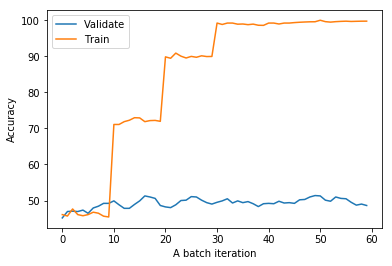

In [169]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

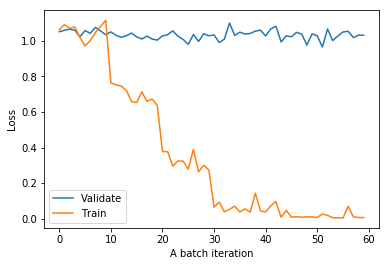

In [170]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (GRU) (slate)

In [171]:
gru = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k')

In [172]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [173]:
criterion = nn.CrossEntropyLoss()

In [174]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_data_loaders[2],\
                                                              val_data_loaders[2],'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_slate',num_epochs=6)

Epoch: [1/6], Step: [4/32], Validation Acc: 41.31736526946108
Epoch: [1/6], Step: [7/32], Validation Acc: 39.02195608782435
Epoch: [1/6], Step: [10/32], Validation Acc: 38.72255489021956
Epoch: [1/6], Step: [13/32], Validation Acc: 38.72255489021956
Epoch: [1/6], Step: [16/32], Validation Acc: 38.82235528942116
Epoch: [1/6], Step: [19/32], Validation Acc: 38.32335329341317
Epoch: [1/6], Step: [22/32], Validation Acc: 39.421157684630735
Epoch: [1/6], Step: [25/32], Validation Acc: 40.01996007984032
Epoch: [1/6], Step: [28/32], Validation Acc: 40.21956087824351
Epoch: [1/6], Step: [31/32], Validation Acc: 38.72255489021956
Epoch: [2/6], Step: [4/32], Validation Acc: 40.5189620758483
Epoch: [2/6], Step: [7/32], Validation Acc: 40.818363273453095
Epoch: [2/6], Step: [10/32], Validation Acc: 40.7185628742515
Epoch: [2/6], Step: [13/32], Validation Acc: 40.21956087824351
Epoch: [2/6], Step: [16/32], Validation Acc: 40.91816367265469
Epoch: [2/6], Step: [19/32], Validation Acc: 41.01796407185

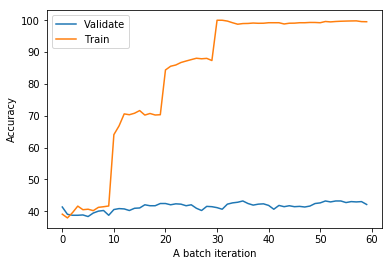

In [175]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

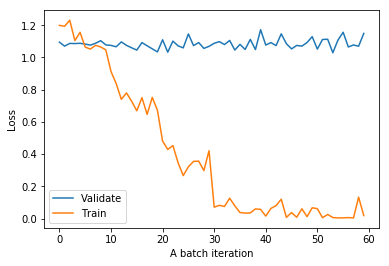

In [176]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (GRU) (telephone)

In [177]:
gru = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k')

In [178]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [179]:
criterion = nn.CrossEntropyLoss()

In [180]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_data_loaders[3],\
                                                              val_data_loaders[3],'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_tele',num_epochs=6)

Epoch: [1/6], Step: [4/34], Validation Acc: 43.482587064676615
Epoch: [1/6], Step: [7/34], Validation Acc: 44.27860696517413
Epoch: [1/6], Step: [10/34], Validation Acc: 46.169154228855724
Epoch: [1/6], Step: [13/34], Validation Acc: 44.5771144278607
Epoch: [1/6], Step: [16/34], Validation Acc: 45.07462686567164
Epoch: [1/6], Step: [19/34], Validation Acc: 44.776119402985074
Epoch: [1/6], Step: [22/34], Validation Acc: 46.169154228855724
Epoch: [1/6], Step: [25/34], Validation Acc: 45.97014925373134
Epoch: [1/6], Step: [28/34], Validation Acc: 46.169154228855724
Epoch: [1/6], Step: [31/34], Validation Acc: 45.27363184079602
Epoch: [1/6], Step: [34/34], Validation Acc: 48.25870646766169
Epoch: [2/6], Step: [4/34], Validation Acc: 48.55721393034826
Epoch: [2/6], Step: [7/34], Validation Acc: 47.960199004975124
Epoch: [2/6], Step: [10/34], Validation Acc: 47.86069651741293
Epoch: [2/6], Step: [13/34], Validation Acc: 47.960199004975124
Epoch: [2/6], Step: [16/34], Validation Acc: 48.65671

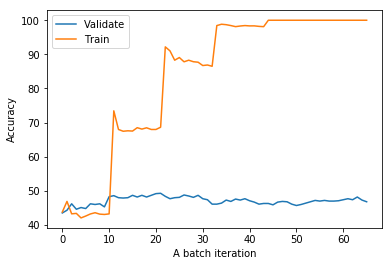

In [181]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

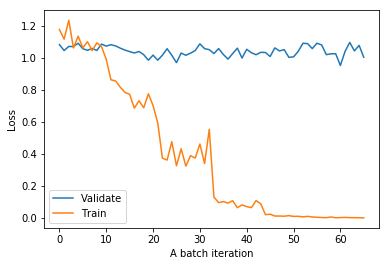

In [182]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Fine-tuning the model (GRU) (travel)

In [183]:
gru = torch.load('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k')

In [184]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [185]:
criterion = nn.CrossEntropyLoss()

In [186]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,train_data_loaders[4],\
                                                              val_data_loaders[4],'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_trav',num_epochs=6)

Epoch: [1/6], Step: [4/32], Validation Acc: 42.46435845213849
Epoch: [1/6], Step: [7/32], Validation Acc: 45.11201629327902
Epoch: [1/6], Step: [10/32], Validation Acc: 43.075356415478616
Epoch: [1/6], Step: [13/32], Validation Acc: 43.9918533604888
Epoch: [1/6], Step: [16/32], Validation Acc: 43.27902240325866
Epoch: [1/6], Step: [19/32], Validation Acc: 43.9918533604888
Epoch: [1/6], Step: [22/32], Validation Acc: 43.686354378818734
Epoch: [1/6], Step: [25/32], Validation Acc: 44.806517311608964
Epoch: [1/6], Step: [28/32], Validation Acc: 45.824847250509166
Epoch: [1/6], Step: [31/32], Validation Acc: 44.70468431771894
Epoch: [2/6], Step: [4/32], Validation Acc: 46.02851323828921
Epoch: [2/6], Step: [7/32], Validation Acc: 45.11201629327902
Epoch: [2/6], Step: [10/32], Validation Acc: 45.723014256619145
Epoch: [2/6], Step: [13/32], Validation Acc: 45.5193482688391
Epoch: [2/6], Step: [16/32], Validation Acc: 45.926680244399186
Epoch: [2/6], Step: [19/32], Validation Acc: 46.33401221

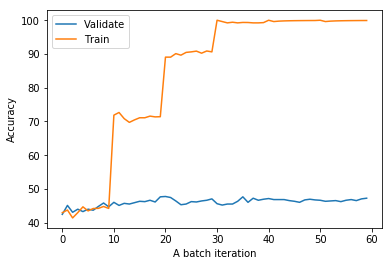

In [187]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

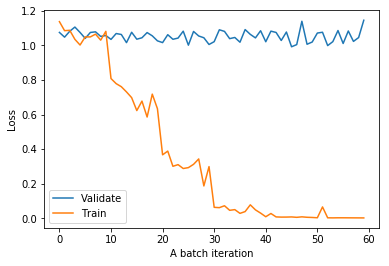

In [188]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# Checking accuracy of the fine-tuned model across genres (GRU)

In [189]:
best_gru_models = ['gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_fic','gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_govt',\
                  'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_slate','gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_tele',\
                  'gru_hd=400_t2_dp=0_max_len=50_multh_200k_ft_trav']

In [198]:
acc_matrix_gru = np.zeros((5,5))
loss_matrix_gru = np.zeros((5,5))
for i,b in enumerate(best_gru_models):
    best_model = torch.load('/scratch/ark576/NLP_HW_2/'+b)
    for j,v in enumerate(val_data_loaders):
        acc_matrix_gru[i,j], loss_matrix_gru[i,j], _ = test_model(v,best_model,criterion)

In [199]:
acc_matrix_gru

array([[48.94472362, 44.48818898, 42.11576846, 43.1840796 , 42.87169043],
       [47.2361809 , 51.18110236, 44.61077844, 43.78109453, 46.13034623],
       [43.91959799, 43.6023622 , 43.01397206, 42.58706468, 44.70468432],
       [44.12060302, 45.96456693, 43.11377246, 48.95522388, 42.97352342],
       [45.92964824, 47.24409449, 42.21556886, 43.9800995 , 47.25050916]])

In [200]:
best_cnn_models = ['cnn_hd=500_ks=3_cath_200k_ft','cnn_hd=500_ks=3_cath_200k_ft_govt',\
                  'cnn_hd=500_ks=3_cath_200k_ft_slate','cnn_hd=500_ks=3_cath_200k_ft_tele',\
                  'cnn_hd=500_ks=3_cath_200k_ft_travel']

In [201]:
acc_matrix_cnn = np.zeros((5,5))
loss_matrix_cnn = np.zeros((5,5))
for i,b in enumerate(best_cnn_models):
    best_model = torch.load('/scratch/ark576/NLP_HW_2/'+b)
    for j,v in enumerate(val_data_loaders):
        acc_matrix_cnn[i,j], loss_matrix_cnn[i,j], _ = test_model(v,best_model,criterion)

In [202]:
acc_matrix_cnn

array([[47.33668342, 41.33858268, 45.00998004, 45.77114428, 46.7413442 ],
       [42.4120603 , 47.83464567, 43.61277445, 45.97014925, 44.60285132],
       [43.51758794, 44.29133858, 45.40918164, 46.66666667, 45.0101833 ],
       [44.72361809, 45.76771654, 44.01197605, 51.04477612, 45.41751527],
       [42.51256281, 47.34251969, 44.11177645, 46.66666667, 48.16700611]])

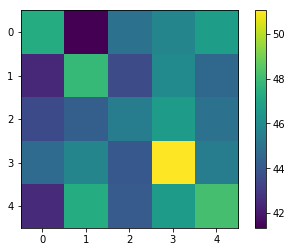

In [206]:
plt.imshow(acc_matrix_cnn)
plt.colorbar()

In [209]:
import seaborn as sns

Text(32.09374999999999, 0.5, 'Models')

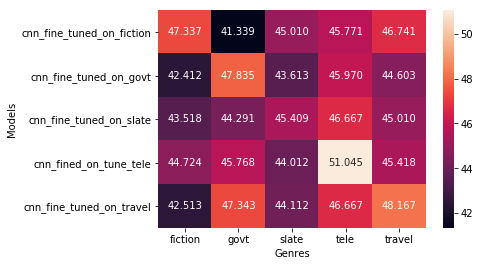

In [422]:
sns.heatmap(acc_matrix_cnn,annot=True,fmt = '.3f', xticklabels=['fiction','govt','slate','tele','travel'],\
           yticklabels = ['cnn_fine_tuned_on_fiction','cnn_fine_tuned_on_govt','cnn_fine_tuned_on_slate','cnn_fined_on_tune_tele','cnn_fine_tuned_on_travel'])
plt.xlabel('Genres')
plt.ylabel('Models')

Text(32.09374999999999, 0.5, 'Models')

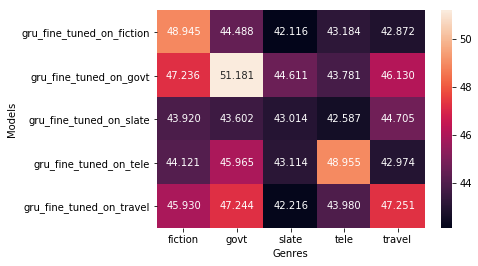

In [421]:
sns.heatmap(acc_matrix_gru,annot=True,fmt = '.3f', xticklabels=['fiction','govt','slate','tele','travel'],\
           yticklabels = ['gru_fine_tuned_on_fiction','gru_fine_tuned_on_govt','gru_fine_tuned_on_slate','gru_fine_tuned_on_tele','gru_fine_tuned_on_travel'])
plt.xlabel('Genres')
plt.ylabel('Models')